# Training species classifier Expt 3: cross-validation of Oswald data
# Feb 23, 2021
## Spatial Pyramid Pooling (SPP): [1, 2, 4]
## The augemented noise is from the all five deployments.
## Trained on PICEAS2005 & STAR2000 whereas tested on HICEAS2002, STAR2003 & STAR2006

In [1]:
import numpy as np
from itertools import permutations
import random
import os
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
from os import makedirs
from datetime import datetime
from collections import Counter

from math import floor

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
import seaborn as sns

from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Conv2D, Lambda, Flatten, MaxPooling2D, Concatenate, LSTM, Reshape, Lambda, ConvLSTM2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Bidirectional, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers.schedules import ExponentialDecay, PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import tensorflow_addons.layers.spatial_pyramid_pooling as spp
# import tensorflow_datasets as tfds
from tensorflow.math import l2_normalize

import tensorflow as tf

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Hyper parameters
learning_rate = 1.0e-3
conv_dim = 16
rnn_dim = 16
pool_size = 2
pool_stride = 2
l2_regu = 0.000
drop_rate = 0.2
hidden_units = 256
fcn_dim = 256

# learning_rate = 1.e-4
# conv_dim = 64
# rnn_dim = 16
# pool_size = 2
# pool_stride = 2
# l2_regu = 0.00
# drop_rate = 0.2
# # drop_rate = 0.5
# hidden_units = 512
# fcn_dim = 512

num_epoch = 200
# batch_size = 128
# batch_size = 32  # for cnn14+attention
batch_size = 16  # for cnn14+spp

num_patience = 20

In [4]:
# data_type_dict = {1: 'universal', 2: 'file', 3: 'encounter', 4: 'domain'}
# data_type = 2

work_path = '/home/ys587/__Data/__whistle/__whislte_30_species'
fit_result_path =  os.path.join(work_path, '__fit_result_species')
# feature_path = os.path.join(work_path, '__feature_species')
feature_path = os.path.join(work_path, '__dataset/20210210')

In [5]:
species_dict = {'BD': 0, 'CD': 1, 'STR': 2, 'SPT': 3, 'SPIN': 4, 'PLT': 5, 'RT': 6,  'FKW': 7}
num_species = len(species_dict)
# species_dict = {'BD': 0, 'MH': 1, 'CD': 2, 'STR': 3, 'SPT': 4, 'SPIN': 5, 'PLT': 6, 'RD': 7, 'RT': 8,
#                 'WSD': 9, 'FKW': 10, 'BEL': 11, 'KW': 12, 'WBD': 13, 'DUSK': 14, 'FRA': 15, 'PKW': 16, 'LPLT': 17,
#                 'CLY': 18, 'SPE': 19, 'ASP': 20}
species_list = list(species_dict.keys())
species_id = list(species_dict.values())

## Combine features

In [6]:
deployment = ['STAR2000', 'STAR2003', 'STAR2006', 'HICEAS2002', 'PICEAS2005']  # oswald_STAR2000_orig.npz, oswald_STAR2000_aug.npz
# feature_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/20210223_augment_all_three_noise_mixed'
feature_path = '/home/ys587/__Data/__whistle/__whislte_30_species/__dataset/20210223_augment_all_three_noise_mixed_class_balanced_min_5'


In [7]:
if False:
    for ee in deployment:
        print(ee)
        ee_others = [ee2 for ee2 in deployment if (ee2 != ee) ]
        fea_train_files_tot = []
        for ee2 in ee_others:
            fea_train_files_tot.append('oswald_'+ee2+'_orig.npz')
            fea_train_files_tot.append('oswald_'+ee2+'_aug.npz')

        # Training data
        fea_train_list = []
        label_train_list = []
        for ii in range(len(fea_train_files_tot)):
            ff = fea_train_files_tot[ii]
            print(ff)
            fea_temp = np.load(os.path.join(feature_path, ff))
            print(fea_temp.files)

            if ii == 0:
                fea_train = fea_temp['feas_orig']
                label_train = fea_temp['labels_orig']
                print(fea_train.shape)
                print(label_train.shape)
            elif ii % 2 == 0:  # even
                fea_train = np.concatenate([fea_train, fea_temp['feas_orig']])
                label_train = np.concatenate([label_train, fea_temp['labels_orig']])
                print(fea_train.shape)
                print(label_train.shape)
            else:
                fea_train = np.concatenate([fea_train, fea_temp['feas_aug']])
                label_train = np.concatenate([label_train, fea_temp['labels_aug']])
                print(fea_train.shape)
                print(label_train.shape)
        print(fea_train.shape)
        print(label_train.shape)
        np.savez(os.path.join(feature_path, './train_oswald_no_'+ee+'.npz'), fea_train=fea_train, label_train=label_train)
        print('')

In [8]:
# data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, feature, label, batch_size=32, num_classes=None, shuffle=True):
        self.batch_size = batch_size
        self.X = feature
        self.X_dim = len(feature.shape)
        self.y = to_categorical(label, num_classes)
        self.indices = np.arange(self.y.shape[0])
        self.num_classes = num_classes
        self.shuffle = shuffle
        
        # self.index = np.arange(len(self.indices))
        #self.df = dataframe
        #self.indices = self.df.index.tolist()        
        # self.x_col = x_col
        # self.y_col = y_col
        
        self.on_epoch_end()

    def __len__(self):
        return int(floor(len(self.indices)/self.batch_size))
        # return label.shape[0]

    def __getitem__(self, index):
        # index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        # batch = [self.indices[k] for k in index]
        batch = list(range(index*self.batch_size, (index+1)*self.batch_size))
        
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        y = np.zeros((self.batch_size, self.y.shape[1]))
        
        if self.X_dim == 3:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2]))
            for i, id in enumerate(batch):
                X[i,:, :] = self.X[id, :, :]  # logic
                y[i, :] = self.y[id, :] # labels
                
        elif self.X_dim == 4:
            X = np.zeros((self.batch_size, self.X.shape[1], self.X.shape[2], self.X.shape[3]))
            for i, id in enumerate(batch):
                X[i,:, :, :] = self.X[id, :, :, :]  # logic
                y[i, :] = self.y[id, :] # labels

        return X, y

## Models

In [9]:
# Kong's attention
# def max_pooling(inputs, **kwargs):
#     input = inputs[0]   # (batch_size, time_steps, freq_bins)
#     return K.max(input, axis=1)
def max_pooling(inputs, **kwargs):
    # input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.max(inputs, axis=1)


def average_pooling(inputs, **kwargs):
    input = inputs[0]   # (batch_size, time_steps, freq_bins)
    return K.mean(input, axis=1)


def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)


def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

In [10]:
# https://github.com/yhenon/keras-spp
# from tensorflow.keras.engine.topology import Layer
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K


class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        # self.dim_ordering = K.image_dim_ordering()
        # self.dim_ordering = K.image_data_format()
        self.dim_ordering  = 'tf'
        print(self.dim_ordering)
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i * i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = K.shape(x)

        if self.dim_ordering == 'th':
            num_rows = input_shape[2]
            num_cols = input_shape[3]
        elif self.dim_ordering == 'tf':
            num_rows = input_shape[1]
            num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]

        outputs = []

        if self.dim_ordering == 'th':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
                        x_crop = x[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

        elif self.dim_ordering == 'tf':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')

                        new_shape = [input_shape[0], y2 - y1,
                                     x2 - x1, input_shape[3]]

                        x_crop = x[:, y1:y2, x1:x2, :]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(1, 2))
                        outputs.append(pooled_val)

        if self.dim_ordering == 'th':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'tf':
            #outputs = K.concatenate(outputs,axis = 1)
            outputs = K.concatenate(outputs)
            #outputs = K.reshape(outputs,(len(self.pool_list),self.num_outputs_per_channel,input_shape[0],input_shape[1]))
            #outputs = K.permute_dimensions(outputs,(3,1,0,2))
            #outputs = K.reshape(outputs,(input_shape[0], self.num_outputs_per_channel * self.nb_channels))

        return outputs

In [11]:
# cnn14 SPP
def model_cnn14_spp(time_steps, freq_bins, classes_num, conv_dim=64, rnn_dim=128, pool_size=2, pool_stride=2, hidden_units=512, l2_regu=0., drop_rate=0., multilabel=True):
    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
#     y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
#     y = Dropout(drop_rate)(y)

#     # group 6
#     y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
#     y = BatchNormalization()(y)
#     y = Activation(activation='relu')(y)
#     y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
#     y = BatchNormalization()(y)
#     y = Activation(activation='relu')(y)
#     y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
#     y = Dropout(drop_rate)(y)
    
    # change dimensions: samples, time, frequency, channels => samples, time, frequency*channels
    #  dim_cnn = K.int_shape(y)
    # y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)
    
    y = spp.SpatialPyramidPooling2D(bins=[1, 2, 4], data_format='channels_last')(y)
    dim_spp = K.int_shape(y)
    y = Reshape((dim_spp[1]*dim_spp[2], ))(y)

    # FC block
    y = Dense(hidden_units, activation='relu', name='cnn14_fcn')(y)  # original 512
    # y = Dense(hidden_units, activation='relu', name='cnn14_fcn2')(y)  # original 512
    x = Dense(classes_num, activation='softmax')(y)
    
    # Build model
    model = Model(inputs=input_layer, outputs=x)
    
    return model

#     a1 = Dense(hidden_units)(y)
#     a1 = BatchNormalization()(a1)
#     a1 = Activation('relu')(a1)
#     a1 = Dropout(drop_rate)(a1)

#     a2 = Dense(hidden_units)(a1)
#     a2 = BatchNormalization()(a2)
#     a2 = Activation('relu')(a2)
#     a2 = Dropout(drop_rate)(a2)
    
#     output_layer = Dense(classes_num, activation='softmax')(a2)

#     if False:
#         # Pooling layers 'decision_level_max_pooling':
#         '''Global max pooling.

#         [1] Choi, Keunwoo, et al. "Automatic tagging using deep convolutional 
#         neural networks." arXiv preprint arXiv:1606.00298 (2016).
#         '''
#         cla = Dense(classes_num, activation='sigmoid')(a2)

#         # output_layer = Lambda(
#         #    max_pooling, 
#         #    output_shape=pooling_shape)(
#         #    [cla])
#         output_layer = Lambda(max_pooling)(cla)

#     # Build model
#     model = Model(inputs=input_layer, outputs=output_layer)
    
#     return model

In [12]:
# cnn14 attention with customized maxpooling
def model_cnn14_attention_multi(time_steps, freq_bins, classes_num, model_type='feature_level_attention', conv_dim=64, rnn_dim=128, pool_size=2, pool_stride=2, hidden_units=512, l2_regu=0., drop_rate=0., multilabel=True):
    # Kong's attention
    # model_type = 'decision_level_max_pooling'  # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_average_pooling' # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_single_attention'
    # model_type = 'decision_level_multi_attention'
    # model_type = 'feature_level_attention'

    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(1, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # change dimensions: samples, time, frequency, channels => samples, time, frequency*channels
    dim_cnn = K.int_shape(y)
    y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)

    a1 = Dense(hidden_units)(y)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    a1 = Dropout(drop_rate)(a1)

    a2 = Dense(hidden_units)(a1)
    a2 = BatchNormalization()(a2)
    a2 = Activation('relu')(a2)
    a2 = Dropout(drop_rate)(a2)

    a3 = Dense(hidden_units)(a2)
    a3 = BatchNormalization()(a3)
    a3 = Activation('relu')(a3)
    a3 = Dropout(drop_rate)(a3)

    # Pooling layers
    if model_type == 'decision_level_max_pooling':
        '''Global max pooling.

        [1] Choi, Keunwoo, et al. "Automatic tagging using deep convolutional 
        neural networks." arXiv preprint arXiv:1606.00298 (2016).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        
        # output_layer = Lambda(
        #    max_pooling, 
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(max_pooling)(cla)

    elif model_type == 'decision_level_average_pooling':
        '''Global average pooling.

        [2] Lin, Min, et al. Qiang Chen, and Shuicheng Yan. "Network in 
        network." arXiv preprint arXiv:1312.4400 (2013).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        # output_layer = Lambda(
        #    average_pooling,
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(average_pooling)(cla)

    elif model_type == 'decision_level_single_attention':
        '''Decision level single attention pooling.
        [3] Kong, Qiuqiang, et al. "Audio Set classification with attention
        model: A probabilistic perspective." arXiv preprint arXiv:1711.00927
        (2017).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        att = Dense(classes_num, activation='softmax')(a3)
        output_layer = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

    elif model_type == 'decision_level_multi_attention':
        '''Decision level multi attention pooling.
        [4] Yu, Changsong, et al. "Multi-level Attention Model for Weakly
        Supervised Audio Classification." arXiv preprint arXiv:1803.02353
        (2018).
        '''
        cla1 = Dense(classes_num, activation='sigmoid')(a2)
        att1 = Dense(classes_num, activation='softmax')(a2)
        out1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla1, att1])

        cla2 = Dense(classes_num, activation='sigmoid')(a3)
        att2 = Dense(classes_num, activation='softmax')(a3)
        out2 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla2, att2])

        b1 = Concatenate(axis=-1)([out1, out2])
        b1 = Dense(classes_num)(b1)
        
        if multilabel:
            output_layer = Activation('sigmoid')(b1)
        else:
            output_layer = Activation('softmax')(b1)

    elif model_type == 'feature_level_attention':
        '''Feature level attention.
        [1] Kong, Qiuqiang, et al. "Weakly labelled audioset tagging with 
        attention neural networks." (2019).
        '''
        cla = Dense(hidden_units, activation='linear')(a3)
        att = Dense(hidden_units, activation='sigmoid')(a3)
        b1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

        b1 = BatchNormalization()(b1)
        b1 = Activation(activation='relu')(b1)
        b1 = Dropout(drop_rate)(b1)
        
        if multilabel:
            output_layer = Dense(classes_num, activation='sigmoid')(b1)
        else:
            output_layer = Dense(classes_num, activation='softmax')(b1)

    else:
        raise Exception("Incorrect model_type!")

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [13]:
# cnn14 attention
def model_cnn14_attention(time_steps, freq_bins, classes_num, model_type='feature_level_attention', conv_dim=64, rnn_dim=128, pool_size=2, pool_stride=2, hidden_units=512, l2_regu=0., drop_rate=0., multilabel=True):
    # Kong's attention
    # model_type = 'decision_level_max_pooling'  # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_average_pooling' # problem with dimensions of the Lambda layer after training
    # model_type = 'decision_level_single_attention'
    # model_type = 'decision_level_multi_attention'
    # model_type = 'feature_level_attention'

    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(pool_size, 2), strides=(pool_stride, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # change dimensions: samples, time, frequency, channels => samples, time, frequency*channels
    dim_cnn = K.int_shape(y)
    y = Reshape((dim_cnn[1], dim_cnn[2]*dim_cnn[3]))(y)

    a1 = Dense(hidden_units)(y)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    a1 = Dropout(drop_rate)(a1)

    a2 = Dense(hidden_units)(a1)
    a2 = BatchNormalization()(a2)
    a2 = Activation('relu')(a2)
    a2 = Dropout(drop_rate)(a2)

    a3 = Dense(hidden_units)(a2)
    a3 = BatchNormalization()(a3)
    a3 = Activation('relu')(a3)
    a3 = Dropout(drop_rate)(a3)

    # Pooling layers
    if model_type == 'decision_level_max_pooling':
        '''Global max pooling.

        [1] Choi, Keunwoo, et al. "Automatic tagging using deep convolutional 
        neural networks." arXiv preprint arXiv:1606.00298 (2016).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        
        # output_layer = Lambda(
        #    max_pooling, 
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(max_pooling)(cla)

    elif model_type == 'decision_level_average_pooling':
        '''Global average pooling.

        [2] Lin, Min, et al. Qiang Chen, and Shuicheng Yan. "Network in 
        network." arXiv preprint arXiv:1312.4400 (2013).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        # output_layer = Lambda(
        #    average_pooling,
        #    output_shape=pooling_shape)(
        #    [cla])
        output_layer = Lambda(average_pooling)(cla)

    elif model_type == 'decision_level_single_attention':
        '''Decision level single attention pooling.
        [3] Kong, Qiuqiang, et al. "Audio Set classification with attention
        model: A probabilistic perspective." arXiv preprint arXiv:1711.00927
        (2017).
        '''
        cla = Dense(classes_num, activation='sigmoid')(a3)
        att = Dense(classes_num, activation='softmax')(a3)
        output_layer = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

    elif model_type == 'decision_level_multi_attention':
        '''Decision level multi attention pooling.
        [4] Yu, Changsong, et al. "Multi-level Attention Model for Weakly
        Supervised Audio Classification." arXiv preprint arXiv:1803.02353
        (2018).
        '''
        cla1 = Dense(classes_num, activation='sigmoid')(a2)
        att1 = Dense(classes_num, activation='softmax')(a2)
        out1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla1, att1])

        cla2 = Dense(classes_num, activation='sigmoid')(a3)
        att2 = Dense(classes_num, activation='softmax')(a3)
        out2 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla2, att2])

        b1 = Concatenate(axis=-1)([out1, out2])
        b1 = Dense(classes_num)(b1)
        
        if multilabel:
            output_layer = Activation('sigmoid')(b1)
        else:
            output_layer = Activation('softmax')(b1)

    elif model_type == 'feature_level_attention':
        '''Feature level attention.
        [1] Kong, Qiuqiang, et al. "Weakly labelled audioset tagging with 
        attention neural networks." (2019).
        '''
        cla = Dense(hidden_units, activation='linear')(a3)
        att = Dense(hidden_units, activation='sigmoid')(a3)
        b1 = Lambda(
            attention_pooling, output_shape=pooling_shape)([cla, att])

        b1 = BatchNormalization()(b1)
        b1 = Activation(activation='relu')(b1)
        b1 = Dropout(drop_rate)(b1)
        
        if multilabel:
            output_layer = Dense(classes_num, activation='sigmoid')(b1)
        else:
            output_layer = Dense(classes_num, activation='softmax')(b1)

    else:
        raise Exception("Incorrect model_type!")

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

In [14]:
def model_cnn14(time_steps, freq_bins, classes_num, pool_size=2, pool_stride=2, conv_dim=16, fcn_dim=512, l2_regu=0., drop_rate=0.):
    # input
    input_layer = Input(shape=(time_steps, freq_bins, 1), name='input')
    
    # group 1
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(input_layer)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 2
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*2, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 3
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*4, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)
    
    # group 4 
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*8, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 5
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*16, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(y)
    y = Dropout(drop_rate)(y)

    # group 6
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    y = Conv2D(conv_dim*32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_regularizer=l2(l2_regu))(y)
    y = BatchNormalization()(y)
    y = Activation(activation='relu')(y)
    
    y = GlobalMaxPooling2D()(y)
    
    # FC block
    y = Dense(fcn_dim, activation='relu', name='cnn14_fcn')(y)  # original 512
    x = Dense(classes_num, activation='softmax')(y)
    
    # Build model
    model = Model(inputs=input_layer, outputs=x)
    
    return model

# Model compile, class weight & fitting

In [15]:
# def find_best_model(model_folder, remove_others=False):
#     model_list = glob.glob(model_folder+'/*.hdf5')
#     model_list.sort()
#     the_best_model = model_list[-1]
    
#     if remove_others==True:
#         for mm in model_list[:-1]:
#             os.remove(mm)
            
#     print(the_best_model)
    
#     return the_best_model
import re

def find_best_model(classifier_path, fmt='epoch_\d+_valloss_(\d+.\d{4})_valacc_\d+.\d{4}.hdf5', is_max=False, purge=True):
    """
    Return the path to the model with the best accuracy, given the path to
    all the trained classifiers
    Args:
        classifier_path: path to all the trained classifiers
        fmt: e.g. "epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5"
        'epoch_\d+_valloss_(\d+.\d{4})_valacc_\d+.\d{4}.hdf5'
        is_max: use max; otherwise, min
        purge: True to purge models files except the best one
    Return:
        the path of the model with the best accuracy
    """
    # list all files ending with .hdf5
    day_list = sorted(glob.glob(os.path.join(classifier_path + '/', '*.hdf5')))

    # re the last 4 digits for accuracy
    hdf5_filename = []
    hdf5_accu = np.zeros(len(day_list))
    for dd in range(len(day_list)):
        filename = os.path.basename(day_list[dd])
        hdf5_filename.append(filename)
        # m = re.search("_F1_(0.\d{4}).hdf5", filename)
        # m = re.search("_([0-1].\d{4}).hdf5", filename)
        # m = re.search("epoch_\d+_[0-1].\d+_(\d+.\d{4}).hdf5", filename)
        m = re.search(fmt, filename)
        try:
            hdf5_accu[dd] = float(m.groups()[0])
        except:
            continue

    # select the laregest one and write to the variable classifier_file
    if len(hdf5_accu) == 0:
        best_model_path = ''
        best_accu = 0
    else:
        if is_max is True:
            ind_max = np.argmax(hdf5_accu)
        else: # use min instead
            ind_max = np.argmin(hdf5_accu)
        best_model_path = day_list[int(ind_max)]
        best_accu = hdf5_accu[ind_max]
        # purge all model files except the best_model
        if purge:
            for ff in day_list:
                if ff != best_model_path:
                    os.remove(ff)
    print('Best model:'+str(best_accu))
    print(best_model_path)
    return best_model_path, best_accu


In [16]:
### cnn4 + attention
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='decision_level_max_pooling', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='decision_level_multi_attention', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# vggish
# model = model_vggish(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim)

# cnn10
# model = model_cnn10(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# cnn14
# model = model_cnn14(dim_time, dim_freq, num_species, conv_dim=conv_dim, fcn_dim=fcn_dim, l2_regu=l2_regu, drop_rate=drop_rate)

# cnn14 attention
# model = model_cnn14_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_bigru_attention(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, rnn_dim=rnn_dim, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)

# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
# loss = CategoricalCrossentropy()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])



In [17]:
boundaries = [20, 40]
values = [1.0e-3, 3.33e-4, 1.0e-4]
learning_rate_fn = PiecewiseConstantDecay(boundaries, values)

# Cross validation

In [18]:
today = datetime.now()
# create a folder based on date & time
fit_result_path1 = os.path.join(fit_result_path, today.strftime('%Y%m%d_%H%M%S'))

## STAR2000

In [19]:
ee = deployment[0]
print(ee)

STAR2000


In [20]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [21]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [22]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [23]:
fea_train = fea_train[:,:100,:]

In [24]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [25]:
Counter(label_train_list)

Counter({'BD': 15028,
         'CD': 4848,
         'FKW': 20160,
         'SPIN': 5734,
         'SPT': 13436,
         'STR': 12528,
         'PLT': 14288,
         'RT': 10944})

In [26]:
Counter(label_test.tolist())

Counter({0.0: 121, 1.0: 3964, 5.0: 31, 6.0: 76, 4.0: 491, 3.0: 845, 2.0: 1140})

In [27]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [28]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (96966, 100, 128)
feature test shape: (6668, 100, 128)
label train shape: (96966,)
label test shape: (6668,)
dim_time: 100
dim_freq: 128


In [29]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [30]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [31]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [32]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [33]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
loss = CategoricalCrossentropy()
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss, metrics=['accuracy'])
model.summary()

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 128, 16)      0     

In [34]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 128, 16)      0     

In [35]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.8903
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/STAR2000/epoch_42_valloss_0.8903_valacc_0.7304.hdf5


In [36]:
model = load_model(the_best_model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 100, 128, 16)      0     

In [37]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [38]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [39]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  38   13   11   21    4    9   13   12]
 [ 652 1603  620  482   22  355  170   60]
 [ 285  147  252  299   12   90   28   27]
 [  65  225   24  442    2   61   19    7]
 [ 216   55   44  142   19    6    1    8]
 [   0    0    0    0    0   25    0    6]
 [  21    6    7    2    1   10   18   11]
 [   0    0    0    0    0    0    0    0]]

[[0.31 0.11 0.09 0.17 0.03 0.07 0.11 0.1 ]
 [0.16 0.4  0.16 0.12 0.01 0.09 0.04 0.02]
 [0.25 0.13 0.22 0.26 0.01 0.08 0.02 0.02]
 [0.08 0.27 0.03 0.52 0.   0.07 0.02 0.01]
 [0.44 0.11 0.09 0.29 0.04 0.01 0.   0.02]
 [0.   0.   0.   0.   0.   0.81 0.   0.19]
 [0.28 0.08 0.09 0.03 0.01 0.13 0.24 0.14]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [40]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

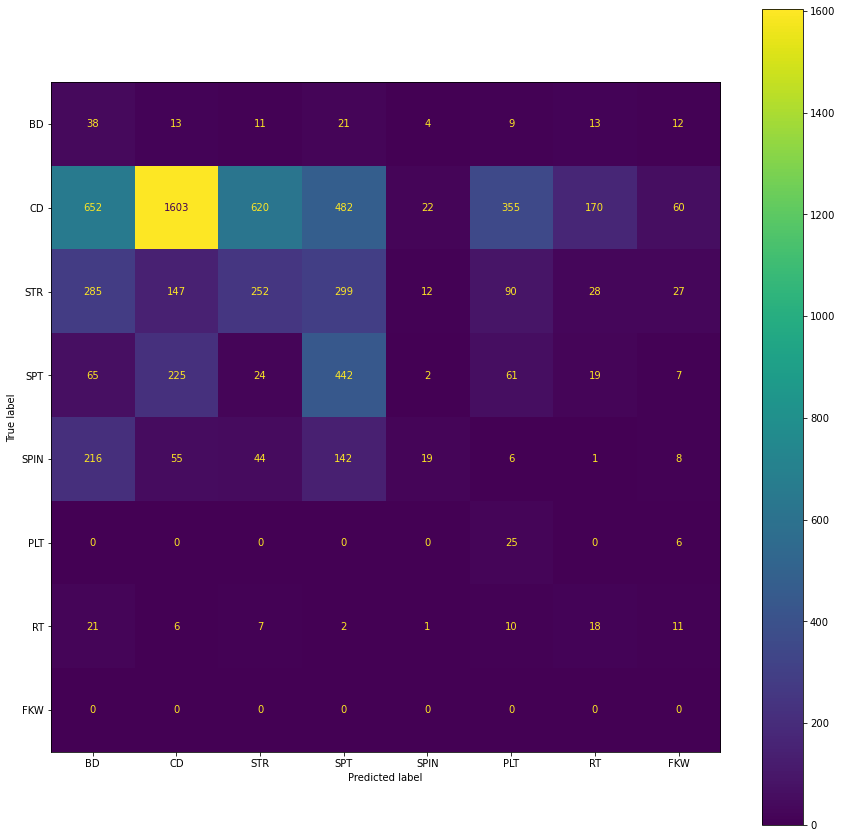

In [41]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


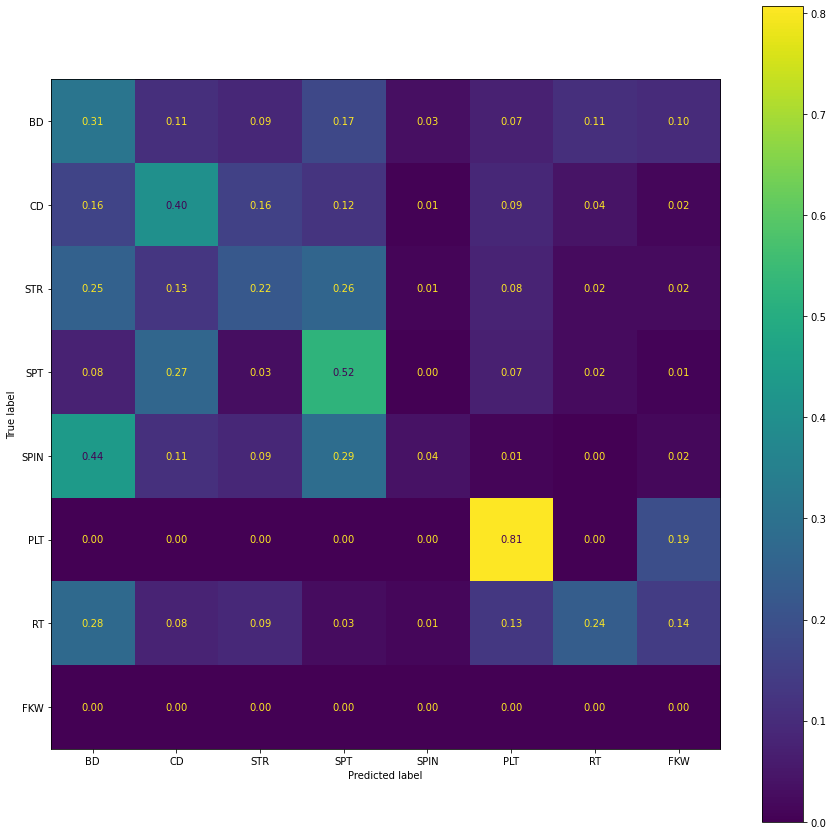

In [42]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

In [158]:
from sklearn.metrics import classification_report
# >>> target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(label_test, np.argmax(label_pred, axis=1), target_names=list(range(num_species))))

/home/ys587/miniconda3/envs/whistle_classifier/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: object of type 'int' has no len()

## top k accuracy score

In [44]:
from sklearn.metrics import top_k_accuracy_score

In [149]:
for kk in range(1, num_species+1):
    print('k='+str(kk)+':  ')
    print(top_k_accuracy_score(label_test, label_pred, k=kk, labels=list(range(num_species))))

k=1:  
0.3631254532269761
k=2:  
0.48912255257432924
k=3:  
0.5656272661348803
k=4:  
0.631979695431472
k=5:  
0.7307831762146483
k=6:  
0.8288614938361131
k=7:  
0.9358230601885424
k=8:  
1.0


/home/ys587/miniconda3/envs/whistle_classifier/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1693: UndefinedMetricWarning: 'k' (8) greater than or equal to 'n_classes' (8) will result in a perfect score and is therefore meaningless.
  warnings.warn(


## average_precision_score

In [51]:
from sklearn.metrics import average_precision_score
from tensorflow.keras.utils import to_categorical

In [52]:
average_precision_score(to_categorical(label_test, num_classes=8), label_pred)

/home/ys587/miniconda3/envs/whistle_classifier/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:817: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


nan

In [53]:
t1=to_categorical(label_test, num_classes=8)

## STAR2003

In [54]:
ee = deployment[1]
print(ee)

STAR2003


In [55]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [56]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [57]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [58]:
fea_train = fea_train[:,:100,:]

In [59]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [60]:
Counter(label_train_list)

Counter({'BD': 14412,
         'CD': 24120,
         'PLT': 14784,
         'RT': 12008,
         'SPIN': 11014,
         'SPT': 18590,
         'STR': 23280,
         'FKW': 17460})

In [61]:
Counter(label_test.tolist())

Counter({0.0: 231, 1.0: 752, 7.0: 270, 4.0: 51, 3.0: 412, 2.0: 54})

In [62]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [63]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (135668, 100, 128)
feature test shape: (1770, 100, 128)
label train shape: (135668,)
label test shape: (1770,)
dim_time: 100
dim_freq: 128


In [64]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [65]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [66]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [67]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [68]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
5932/5935 [============================>.] - ETA: 0s - loss: 1.7780 - accuracy: 0.3004
Epoch 00001: val_loss improved from inf to 1.83307, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/STAR2003/epoch_01_valloss_1.8331_valacc_0.3076.hdf5
5935/5935 [==============================] - 93s 16ms/step - loss: 1.7778 - accuracy: 0.3005 - val_loss: 1.8331 - val_accuracy: 0.3076
Epoch 2/200
5933/5935 [============================>.] - ETA: 0s - loss: 1.4008 - accuracy: 0.4702
Epoch 00002: val_loss improved from 1.83307 to 1.31272, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/STAR2003/epoch_02_valloss_1.3127_valacc_0.5044.hdf5
5935/5935 [==============================] - 93s 16ms/step - loss: 1.4009 - accuracy: 0.4702 - val_loss: 1.3127 - val_accuracy: 0.5044
Epoch 3/200
5932/5935 [============================>.] - ETA: 0s - loss: 1.2788 - accuracy: 0.5207
Epoch 00003: va

In [69]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.7465
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/STAR2003/epoch_22_valloss_0.7465_valacc_0.7298.hdf5


In [70]:
model = load_model(the_best_model)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_10 (Activation)   (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_11 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_11 (Activation)   (None, 100, 128, 16)      0   

In [71]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [72]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [73]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[ 16   7  82  43  29  21  33   0]
 [ 14 305 182  92   6  70  75   8]
 [  0   1  19   3   0   9  16   6]
 [  1  36 144 144   2  67  15   3]
 [  0   3  22  21   2   0   1   2]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   1   0   1   0  26  29 213]]

[[0.07 0.03 0.35 0.19 0.13 0.09 0.14 0.  ]
 [0.02 0.41 0.24 0.12 0.01 0.09 0.1  0.01]
 [0.   0.02 0.35 0.06 0.   0.17 0.3  0.11]
 [0.   0.09 0.35 0.35 0.   0.16 0.04 0.01]
 [0.   0.06 0.43 0.41 0.04 0.   0.02 0.04]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.1  0.11 0.79]]


In [74]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

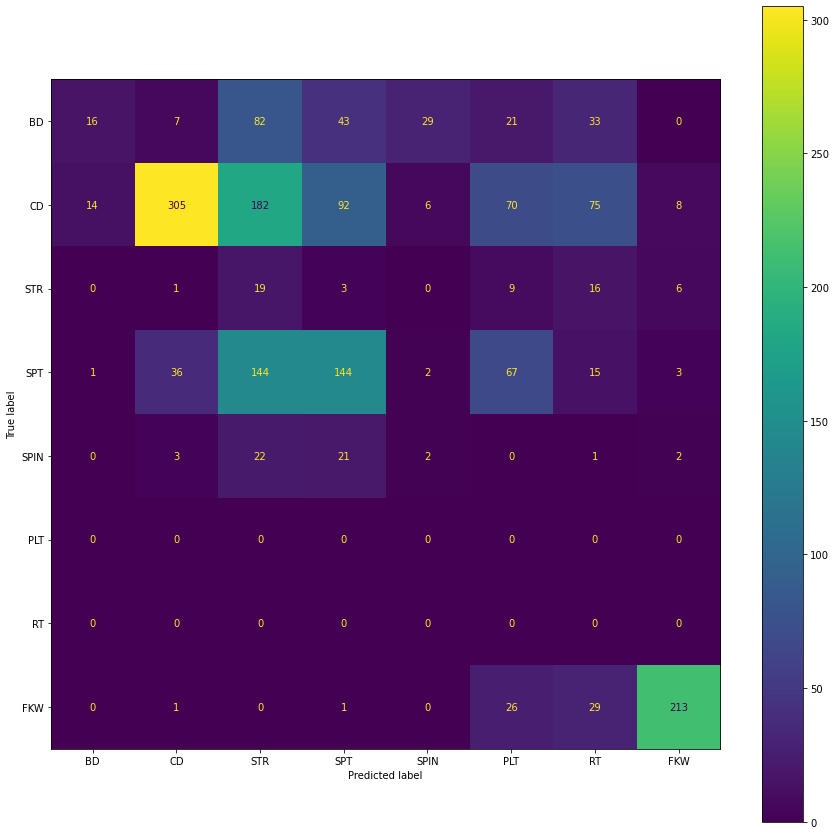

In [75]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


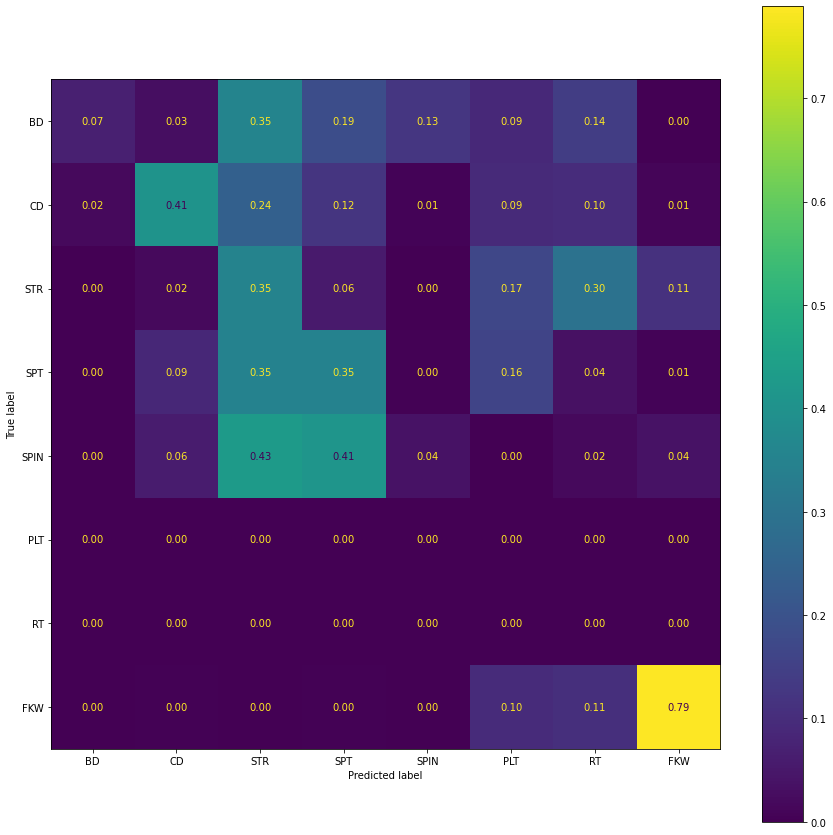

In [76]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## STAR2006

In [77]:
ee = deployment[2]
print(ee)

STAR2006


In [78]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [79]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [80]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [81]:
fea_train = fea_train[:,:100,:]

In [82]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [83]:
Counter(label_train_list)

Counter({'BD': 16722,
         'CD': 28296,
         'PLT': 9728,
         'RT': 11456,
         'SPIN': 11586,
         'SPT': 20416,
         'STR': 17928,
         'FKW': 14742})

In [84]:
Counter(label_test.tolist())

Counter({1.0: 24, 7.0: 903, 5.0: 632, 6.0: 46, 4.0: 2, 3.0: 147, 2.0: 750})

In [85]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [86]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (130874, 100, 128)
feature test shape: (2504, 100, 128)
label train shape: (130874,)
label test shape: (2504,)
dim_time: 100
dim_freq: 128


In [87]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [88]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [89]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [90]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [91]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
5723/5725 [============================>.] - ETA: 0s - loss: 1.7588 - accuracy: 0.3076
Epoch 00001: val_loss improved from inf to 1.59920, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/STAR2006/epoch_01_valloss_1.5992_valacc_0.3798.hdf5
5725/5725 [==============================] - 86s 15ms/step - loss: 1.7589 - accuracy: 0.3075 - val_loss: 1.5992 - val_accuracy: 0.3798
Epoch 2/200
5724/5725 [============================>.] - ETA: 0s - loss: 1.4069 - accuracy: 0.4569
Epoch 00002: val_loss improved from 1.59920 to 1.39259, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/STAR2006/epoch_02_valloss_1.3926_valacc_0.4643.hdf5
5725/5725 [==============================] - 86s 15ms/step - loss: 1.4069 - accuracy: 0.4569 - val_loss: 1.3926 - val_accuracy: 0.4643
Epoch 3/200
5723/5725 [============================>.] - ETA: 0s - loss: 1.2897 - accuracy: 0.5023
Epoch 00003: va

In [92]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.9036
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/STAR2006/epoch_28_valloss_0.9036_valacc_0.6912.hdf5


In [93]:
model = load_model(the_best_model)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization_20 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_20 (Activation)   (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_21 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_21 (Activation)   (None, 100, 128, 16)      0   

In [94]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [95]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [96]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  0   0   0   0   0   0   0   0]
 [ 11   5   2   0   1   4   1   0]
 [142 119 329 101  40  10   6   3]
 [125   2   2   1  15   1   0   1]
 [  1   0   0   0   1   0   0   0]
 [205  35  24  26  30 237  43  32]
 [ 13   3   3   0   6   2  17   2]
 [ 14  17  21   2  10  80  30 729]]

[[0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.46 0.21 0.08 0.   0.04 0.17 0.04 0.  ]
 [0.19 0.16 0.44 0.13 0.05 0.01 0.01 0.  ]
 [0.85 0.01 0.01 0.01 0.1  0.01 0.   0.01]
 [0.5  0.   0.   0.   0.5  0.   0.   0.  ]
 [0.32 0.06 0.04 0.04 0.05 0.38 0.07 0.05]
 [0.28 0.07 0.07 0.   0.13 0.04 0.37 0.04]
 [0.02 0.02 0.02 0.   0.01 0.09 0.03 0.81]]


In [97]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

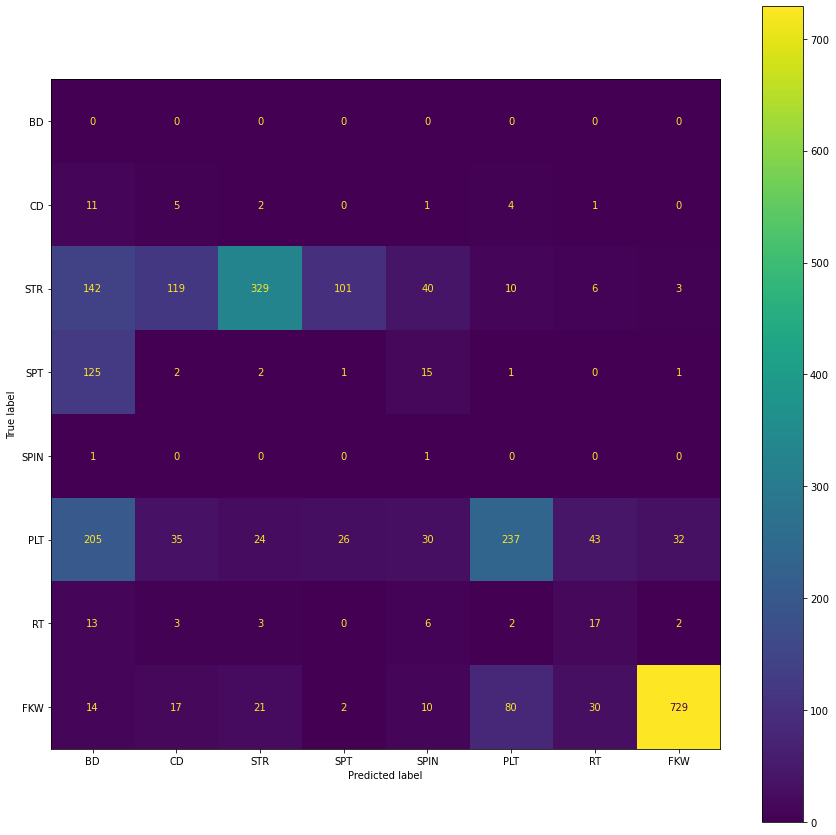

In [98]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


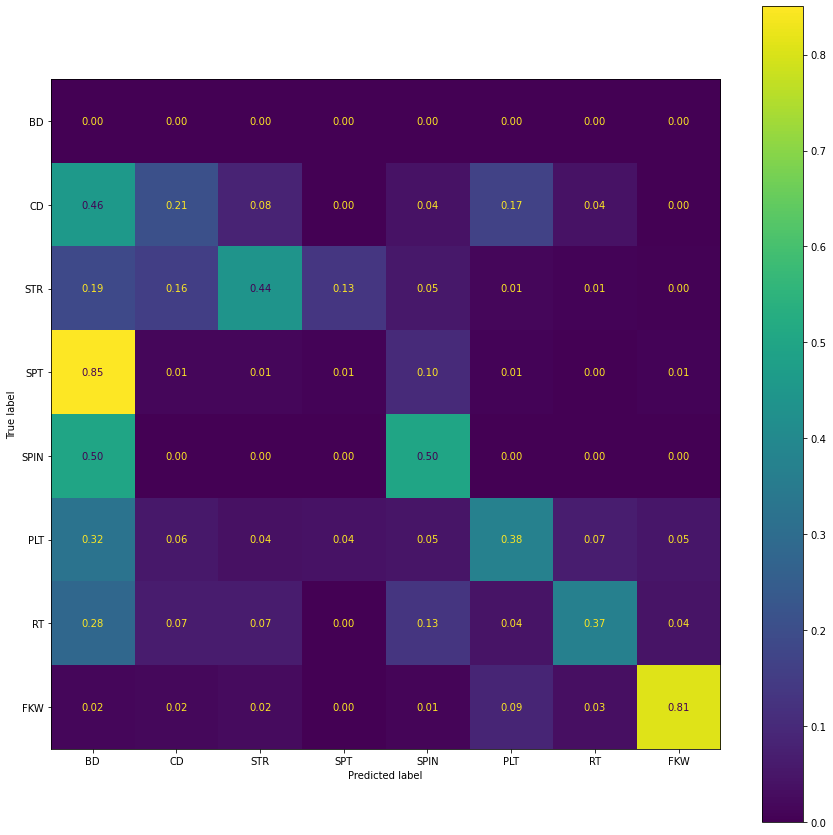

In [99]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## HICEAS2002

In [100]:
ee = deployment[3]
print(ee)

HICEAS2002


In [101]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [102]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [103]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [104]:
fea_train = fea_train[:,:100,:]

In [105]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [106]:
Counter(label_train_list)

Counter({'BD': 16148,
         'CD': 28632,
         'PLT': 8472,
         'RT': 6016,
         'SPIN': 10594,
         'SPT': 18036,
         'STR': 21768,
         'FKW': 20160})

In [107]:
Counter(label_test.tolist())

Counter({0.0: 41, 5.0: 1052, 6.0: 749, 4.0: 86, 3.0: 385, 2.0: 216})

In [108]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [109]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (129826, 100, 128)
feature test shape: (2529, 100, 128)
label train shape: (129826,)
label test shape: (2529,)
dim_time: 100
dim_freq: 128


In [110]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [111]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [112]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [113]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [114]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
5677/5679 [============================>.] - ETA: 0s - loss: 1.7810 - accuracy: 0.2989
Epoch 00001: val_loss improved from inf to 1.66252, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/HICEAS2002/epoch_01_valloss_1.6625_valacc_0.3468.hdf5
5679/5679 [==============================] - 83s 15ms/step - loss: 1.7809 - accuracy: 0.2990 - val_loss: 1.6625 - val_accuracy: 0.3468
Epoch 2/200
5676/5679 [============================>.] - ETA: 0s - loss: 1.4014 - accuracy: 0.4552
Epoch 00002: val_loss improved from 1.66252 to 1.47203, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/HICEAS2002/epoch_02_valloss_1.4720_valacc_0.4445.hdf5
5679/5679 [==============================] - 83s 15ms/step - loss: 1.4015 - accuracy: 0.4552 - val_loss: 1.4720 - val_accuracy: 0.4445
Epoch 3/200
5677/5679 [============================>.] - ETA: 0s - loss: 1.2831 - accuracy: 0.5028
Epoch 00003

In [115]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.7789
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/HICEAS2002/epoch_31_valloss_0.7789_valacc_0.7251.hdf5


In [116]:
model = load_model(the_best_model)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization_30 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_30 (Activation)   (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_31 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_31 (Activation)   (None, 100, 128, 16)      0   

In [117]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [118]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [119]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[  2  14   6   2   1   3   6   7]
 [  0   0   0   0   0   0   0   0]
 [ 35  37 105   8  24   0   0   7]
 [ 75  40 107 126  37   0   0   0]
 [  9  10   9   0   1   2  29  26]
 [ 27 126  90  20  17 628  15 129]
 [ 23 101  63  10  10  13 211 318]
 [  0   0   0   0   0   0   0   0]]

[[0.05 0.34 0.15 0.05 0.02 0.07 0.15 0.17]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.16 0.17 0.49 0.04 0.11 0.   0.   0.03]
 [0.19 0.1  0.28 0.33 0.1  0.   0.   0.  ]
 [0.1  0.12 0.1  0.   0.01 0.02 0.34 0.3 ]
 [0.03 0.12 0.09 0.02 0.02 0.6  0.01 0.12]
 [0.03 0.13 0.08 0.01 0.01 0.02 0.28 0.42]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [120]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

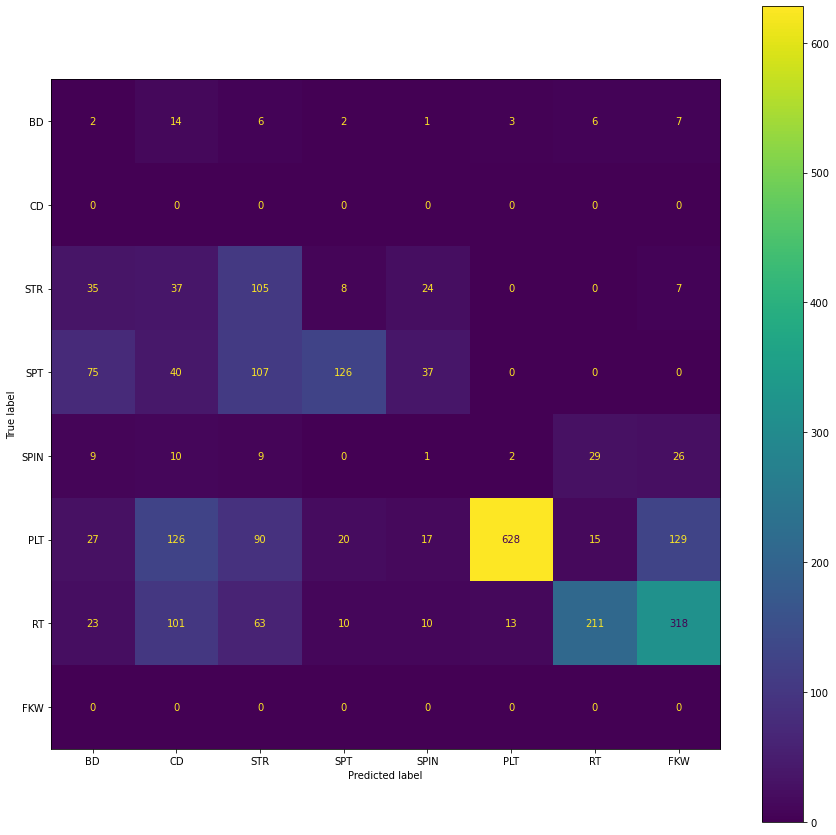

In [121]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


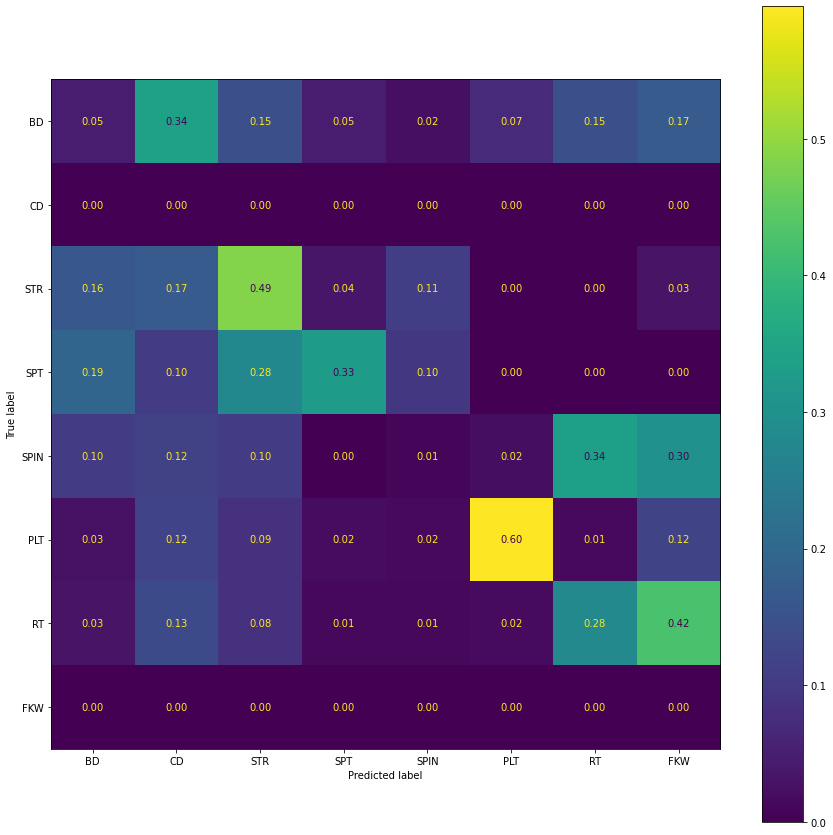

In [122]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)

## PICES2005

In [123]:
ee = deployment[4]
print(ee)

PICEAS2005


In [124]:
# Training data
fea_temp = np.load(os.path.join(feature_path, 'train_oswald_no_'+ee+'.npz'))
fea_train = fea_temp['fea_train']
label_train_list = fea_temp['label_train']
del fea_temp

In [125]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [126]:
# Testing data
fea_temp = np.load(os.path.join(feature_path, 'oswald_'+ee+'_orig.npz'))
fea_test = fea_temp['feas_orig']
label_test_list = fea_temp['labels_orig']

fea_test = fea_test[:,:100,:]
label_test = np.zeros(len(label_test_list))
for ii in range(len(label_test_list)):
    label_test[ii] = species_dict[label_test_list[ii]]

In [127]:
fea_train = fea_train[:,:100,:]

In [128]:
label_train = np.zeros(len(label_train_list))
for ii in range(len(label_train_list)):
    label_train[ii] = species_dict[label_train_list[ii]]

In [129]:
Counter(label_train_list)

Counter({'BD': 4578,
         'CD': 28632,
         'PLT': 11864,
         'RT': 7608,
         'SPIN': 7576,
         'SPT': 17066,
         'STR': 20208,
         'FKW': 8118})

In [130]:
Counter(label_test.tolist())

Counter({0.0: 1518,
         7.0: 2007,
         5.0: 292,
         6.0: 440,
         4.0: 405,
         3.0: 482,
         2.0: 372})

In [131]:
fit_result_path2 = os.path.join(fit_result_path1, ee)
if not os.path.exists(fit_result_path2):
    makedirs(fit_result_path2)

In [132]:
print('feature train shape: '+str(fea_train.shape))
print('feature test shape: '+str(fea_test.shape))
print('label train shape: '+str(label_train.shape))
print('label test shape: '+str(label_test.shape))

dim_time = fea_train.shape[1]
dim_freq = fea_train.shape[2]
print('dim_time: '+str(dim_time))
print('dim_freq: '+str(dim_freq))

feature train shape: (105650, 100, 128)
feature test shape: (5516, 100, 128)
label train shape: (105650,)
label test shape: (5516,)
dim_time: 100
dim_freq: 128


In [133]:
# shuffle features & labels
fea_train, label_train = shuffle(fea_train, label_train, random_state=0)
fea_test, label_test = shuffle(fea_test, label_test, random_state=0)

In [134]:
# class weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_train), y=label_train)

class_weights = dict()
for ii in range(num_species):
    class_weights[ii] = weights[ii]

In [135]:
fea_train = np.expand_dims(fea_train, axis=3)
fea_test = np.expand_dims(fea_test, axis=3)

In [136]:
fea_train, fea_validate, label_train, label_validate = train_test_split(fea_train, label_train, test_size=0.30, random_state=42)

train_generator = DataGenerator(fea_train, label_train, batch_size=batch_size, num_classes=num_species)
del fea_train
validate_generator = DataGenerator(fea_validate, label_validate, batch_size=batch_size, num_classes=num_species)
del fea_validate

# test_generator = DataGenerator(fea_test, label_test, batch_size=batch_size, num_classes=num_species)


### Training the model

In [137]:
# model = model_cnn14_attention_multi(dim_time, dim_freq, num_species, model_type='feature_level_attention', conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
model = model_cnn14_spp(dim_time, dim_freq, num_species, conv_dim=conv_dim, pool_size=pool_size, pool_stride=pool_stride, hidden_units=hidden_units, l2_regu=l2_regu, drop_rate=drop_rate)
loss = CategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn), loss=loss, metrics=['accuracy'])

# With classes
# history = model.fit(fea_train, to_categorical(label_train), class_weight=class_weights, validation_split=0.3, batch_size=batch_size, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience), ModelCheckpoint(filepath=os.path.join(fit_result_path, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
# history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path1), ModelCheckpoint(filepath=os.path.join(fit_result_path1, '{epoch:02d}-{val_loss:.4f}.hdf5'), verbose=1, monitor="val_loss", save_best_only=True)])
history = model.fit(train_generator, validation_data=validate_generator, class_weight=class_weights, epochs=num_epoch, callbacks=[EarlyStopping(patience=num_patience, monitor='val_loss', mode='min', verbose=1), TensorBoard(log_dir=fit_result_path2), ModelCheckpoint(filepath=os.path.join(fit_result_path2, 'epoch_{epoch:02d}_valloss_{val_loss:.4f}_valacc_{val_accuracy:.4f}.hdf5' ), verbose=1, monitor="val_loss", save_best_only=True)])

Epoch 1/200
4619/4622 [============================>.] - ETA: 0s - loss: 1.7960 - accuracy: 0.2779
Epoch 00001: val_loss improved from inf to 1.81926, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/PICEAS2005/epoch_01_valloss_1.8193_valacc_0.2949.hdf5
4622/4622 [==============================] - 69s 15ms/step - loss: 1.7959 - accuracy: 0.2780 - val_loss: 1.8193 - val_accuracy: 0.2949
Epoch 2/200
4621/4622 [============================>.] - ETA: 0s - loss: 1.4111 - accuracy: 0.4560
Epoch 00002: val_loss improved from 1.81926 to 1.43157, saving model to /home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/PICEAS2005/epoch_02_valloss_1.4316_valacc_0.4531.hdf5
4622/4622 [==============================] - 68s 15ms/step - loss: 1.4111 - accuracy: 0.4560 - val_loss: 1.4316 - val_accuracy: 0.4531
Epoch 3/200
4619/4622 [============================>.] - ETA: 0s - loss: 1.2743 - accuracy: 0.5081
Epoch 00003

In [138]:
# fit_result_path1 = '/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210210_224527'
the_best_model, _ = find_best_model(fit_result_path2, purge=False)

Best model:0.8631
/home/ys587/__Data/__whistle/__whislte_30_species/__fit_result_species/20210224_190600/PICEAS2005/epoch_27_valloss_0.8631_valacc_0.6977.hdf5


In [139]:
model = load_model(the_best_model)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100, 128, 1)]     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization_40 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_40 (Activation)   (None, 100, 128, 16)      0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_41 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
activation_41 (Activation)   (None, 100, 128, 16)      0   

In [140]:
label_pred = model.predict(fea_test)
# label_pred = model.predict(test_generator)

In [141]:
np.set_printoptions(linewidth=200, precision=2, suppress=True)

In [142]:
print("Confusion matrix:")
cm = confusion_matrix(label_test, np.argmax(label_pred, axis=1), labels=species_id)

print(species_list)
print('')
print(cm)
print('')

cm2 = cm*1.0
for ii in range(cm.shape[0]):
    cm_row = cm[ii, :]*1.0

    cm_row_sum = cm_row.sum()
    if cm_row_sum != 0:
        cm2[ii, :] = cm_row / cm_row_sum
    else:
        cm2[ii, :] = np.zeros(cm.shape[1])

print(cm2)

Confusion matrix:
['BD', 'CD', 'STR', 'SPT', 'SPIN', 'PLT', 'RT', 'FKW']

[[ 59 311 464 292 155 187  47   3]
 [  0   0   0   0   0   0   0   0]
 [  6  19 274  40  12  11   9   1]
 [ 15  13 118 271  42  11  12   0]
 [  7  42 131 105  84  29   6   1]
 [  6  19   5   2   1 206  41  12]
 [ 15  12  16   5  17  48 303  24]
 [ 25  29  75  13  38 273 748 806]]

[[0.04 0.2  0.31 0.19 0.1  0.12 0.03 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.05 0.74 0.11 0.03 0.03 0.02 0.  ]
 [0.03 0.03 0.24 0.56 0.09 0.02 0.02 0.  ]
 [0.02 0.1  0.32 0.26 0.21 0.07 0.01 0.  ]
 [0.02 0.07 0.02 0.01 0.   0.71 0.14 0.04]
 [0.03 0.03 0.04 0.01 0.04 0.11 0.69 0.05]
 [0.01 0.01 0.04 0.01 0.02 0.14 0.37 0.4 ]]


In [143]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=species_list)

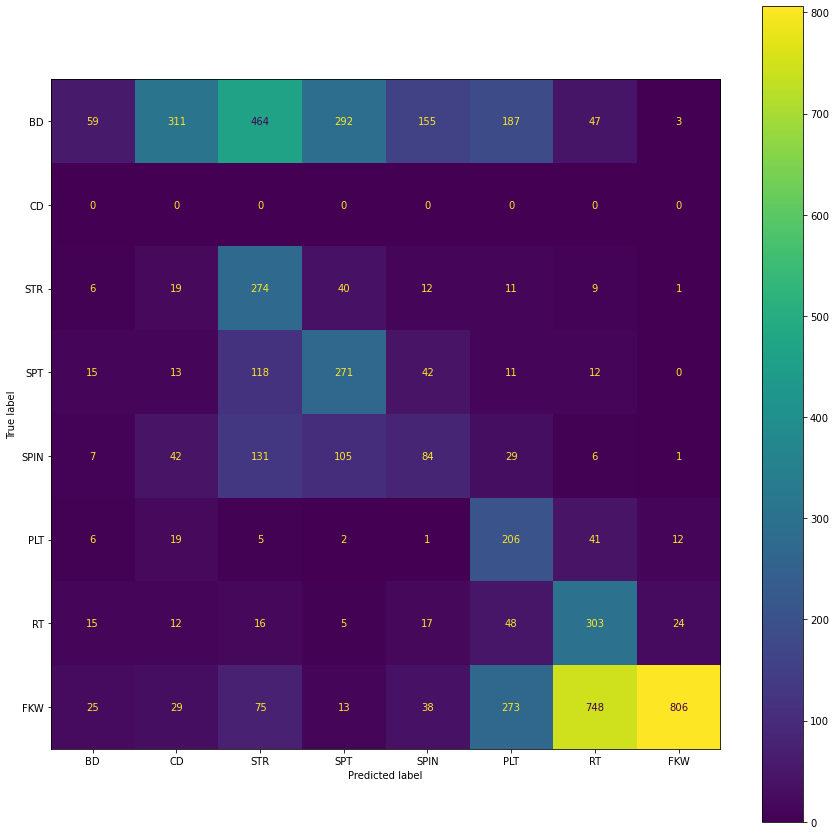

In [144]:
fig, ax = plt.subplots(figsize=[15, 15])
disp.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format=None, colorbar=True)


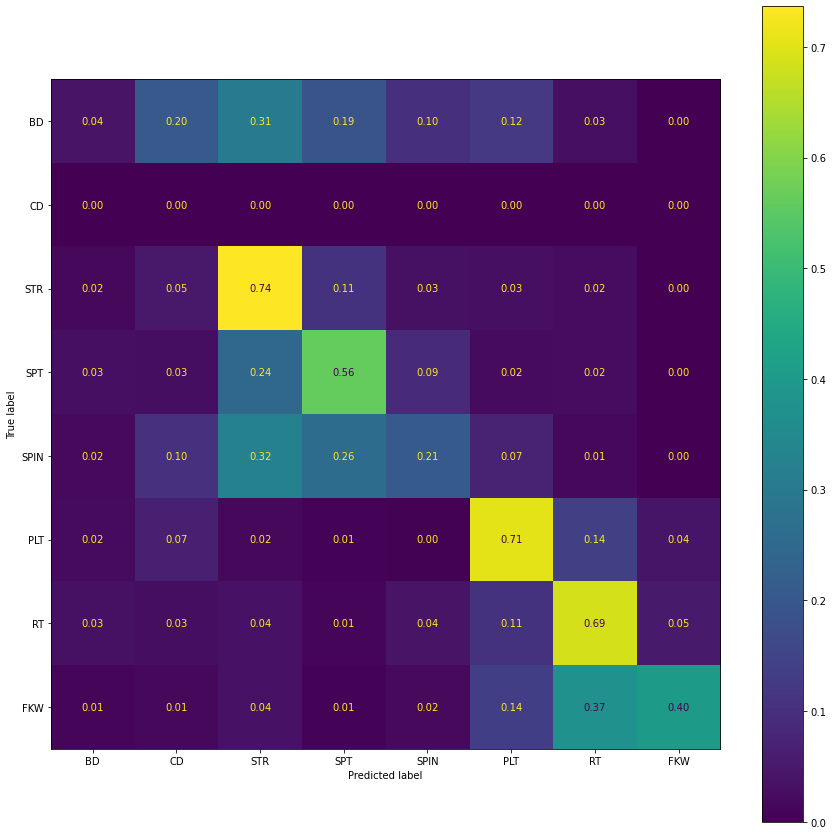

In [145]:
fig, ax = plt.subplots(figsize=[15, 15])
disp2.plot(include_values=True,
                     cmap='viridis', ax=ax, xticks_rotation='horizontal',
                     values_format='.2f', colorbar=True)